In [1]:
import os
import rembg
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt

In [2]:
def widest_boundary(image,left,right,bottom):
    # determines the y-coordinate of the widest part of the guitar, which is expected to be within the lower half of the guitar's top section. 
    # this part is identified by analyzing each horizontal line (row) from the bottom to the top of the image and finding the row with the longest continuous sequence of non-transparent pixels. 
    # this is done to avoid the influence of any guitar stand in the image by not extending the search to the very bottom.
    # the y-coordinate of the row with this longest sequence is considered to be where the guitar is widest, 
    # which is used as a reference point for further processing such as determining left and right boundaries with reduced impact from the guitar stand.

    # initialize the y location and the number of continuous non-transparent pixels
    max_num_pixel = 0
    y_b = 0
    
    # iterates over each row
    for y in range(bottom):
        # extract the pixel sequence
        column = [image.getpixel((x, y)) for x in range(left,right)]
        
        # initialize variables for calculation of the length of continuous non-transparent pixels
        num_continous_pixels = []
        num_pixel = 0
        
        # count the length of continuous non-transparent pixels
        for pixel in column:
            if pixel[3] > 0:
                num_pixel += 1
            else:
                num_continous_pixels.append(num_pixel)
                num_pixel = 0
        
        # find the maximum of length of continuous non-transparent pixels within a row
        num_pixel = max(num_continous_pixels)
        
        # find the maximum of length of continuous non-transparent pixels throughout all rows
        if num_pixel >= max_num_pixel:  # Count non-transparent pixels
            max_num_pixel = num_pixel
            y_b = y

    return y_b

def left_boundary(image, top, bottom, pixel_count, offset):
    # iterate over columns from the left side
    for x in range(image.width):
        # find the number of non-transparent pixels
        column = [image.getpixel((x, y)) for y in range(top, bottom)]
        num_pixel = sum(1 for pixel in column if pixel[3] > 0)
        
        # if the number is more than a threshold then determine the x as the left boundary
        if num_pixel >= pixel_count:  # Count non-transparent pixels
            left_boundary = x + offset
            return left_boundary

def right_boundary(image, top, bottom, pixel_count, offset):
    # iterate over columns from the right side
    for x in range(image.width-1,-1,-1):
        # find the number of non-transparent pixels
        column = [image.getpixel((x, y)) for y in range(top, bottom)]
        num_pixel = sum(1 for pixel in column if pixel[3] > 0)
        
        # if the number is more than a threshold then determine the x as the right boundary
        if num_pixel >= pixel_count:  # Count non-transparent pixels
            right_boundary = x - offset
            return right_boundary        

def bottom_boundary(image, left, right, pixel_count, offset):
    # iterate over columns from the bottom
    for y in range(image.width-1,-1,-1):
        # find the number of non-transparent pixels
        column = [image.getpixel((x, y)) for x in range(left,right)]
        num_pixel = sum(1 for pixel in column if pixel[3] > 0)
        
        # if the number is more than a threshold then determine the y as the bottom boundary
        if  num_pixel >= pixel_count:  
            right_boundary = y - offset
            return right_boundary         

def top_boundary(image, left, right, bottom, offset):
    # iterate over columns from the bottom
    for y in range(bottom,-1,-1):
        # find the number of non-transparent pixels
        column = [image.getpixel((x, y)) for x in range(left,right)]
        num_pixel = sum(1 for pixel in column if pixel[3] > 0)
        
        # if the number is less than a ratio and the width-height ratio is less than 2 determine the y as the top boundary
        # this is because we think that the length fingerboard of guitar divided by the length of widest part of guitar should be less than a ratio
        # the ratio can vary based on the image, but still be in a range
        for ratio in range(31,10,-1):
            if num_pixel < ratio / 100 * (right - left) and (bottom - y) < 2 * (right - left):
                return y + offset

def crop_image(image):
    # Convert to RGBA if not already in that mode
    if image.mode != 'RGBA':
        image = image.convert('RGBA')

    # Initialize boundaries
    left = 0
    top = 0
    right = 600
    bottom = 600

    # find the widest part of the guitar image
    widest_y = widest_boundary(image,left,right,bottom)
    # find the left boundary of the guitar image
    left_b = left_boundary(image, 0, widest_y, 15, 3)
    # find the right boundary of the guitar image
    right_b = right_boundary(image, 0, widest_y, 15, 3)
    # calculate the midpoint of left and right boundary
    mid = int((left_b + right_b)/2)
    # set an interval centered around the midpoint to search for the bottom boundary
    width = 10
    # find the bottom boundary of the guitar image
    bottom_b = bottom_boundary(image, mid - width, mid + width, 5, 0)
    # find the top boundary of the guitar image
    top_b = top_boundary(image, left_b, right_b, widest_y, 0)

    # crop the image
    cropped_image = image.crop((left_b, top_b, right_b, bottom_b))
    return cropped_image

def resize_pad(image,target_size):
    # resize guitar image to square by downsampling and then padding transparently.
    # get the width and height from original image
    width, height = image.size
    
    # calculate the scale_ratio
    scale_ratio = target_size / height
    
    # calculate the size after downsampling
    new_size =  [math.floor(scale_ratio * width), math.floor(scale_ratio * height)]
    
    # resize the image
    image_resized = image.resize(new_size, Image.LANCZOS)
    width_r, height_r = image_resized.size
    
    # create a transparent background image
    new_image = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    
    # pad the image by pasting the resized image in the middle of background image
    upper_x = (target_size - width_r) // 2
    upper_y = 0
    new_image.paste(image_resized, (upper_x, upper_y),image_resized)
    
    return new_image

In [3]:
# remove the background of guitar images
input_path = "D:/Study Abroad/course/CSE498/project/guitar_images"
output_path = "D:/Study Abroad/course/CSE498/project/guitar_no_background_images"
# walk through all guitar images
for root, dirs, files in os.walk(input_path):
    for file in files:
        input_file_path = os.path.join(root, file)
        # Load the input image
        input_image = Image.open(input_file_path)
        # Convert the input image to a numpy array
        input_array = np.array(input_image)

        # Apply background removal using rembg
        output_array = rembg.remove(input_array)

        # Create a PIL Image from the output array
        output_image = Image.fromarray(output_array)
        
        file = file.replace("jpg","png")
        output_file_path = os.path.join(output_path, file)
        
        # Save the output image
        output_image.save(output_file_path)

In [4]:
# manually eliminated invalid images and save the valid ones
input_path = "D:/Study Abroad/course/CSE498/project/guitar_manually_filtered_images"
output_path = "D:/Study Abroad/course/CSE498/project/guitar_cropped_images"
output_path_failed = "D:/Study Abroad/course/CSE498/project/guitar_failed_cropped_images"

In [5]:
# crop the images to keep the top soundboard of guitars exclusively
# walk through all guitar images
for root, dirs, files in os.walk(input_path):
    for file in files:
        input_file_path = os.path.join(root, file)
        # Load the input image
        input_image = Image.open(input_file_path)
        # crop the image
        try:
            output_image = crop_image(input_image)
            output_file_path = os.path.join(output_path, file)
            # Save the output image
            output_image.save(output_file_path)
        except:
            # if the cropping algorithm fails, save the original image to another path.
            output_image = input_image
            output_file_path = os.path.join(output_path_failed, file)
            # Save the output image
            output_image.save(output_file_path)

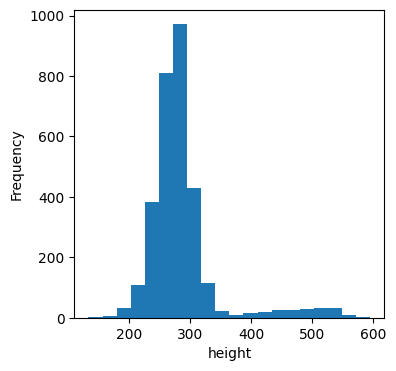

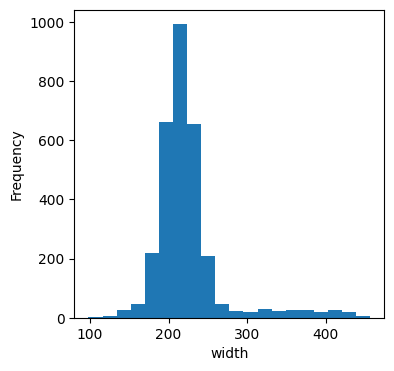

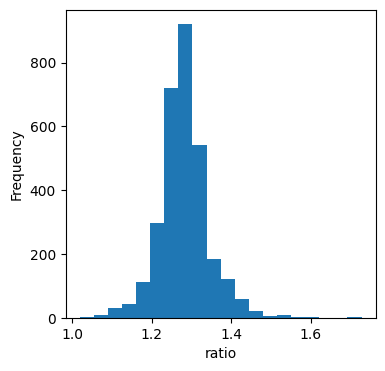

In [6]:
# create variables to store width, height, and ratio for each cropped guitar images
widths = []
heights = []
ratios = []

# inspect the distribution of the height, width and aspect ratio of cropped images
for root, dirs, files in os.walk(output_path):
    for file in files:
        file_path = os.path.join(root, file)
        # Load the input image
        image = Image.open(file_path)
        width, height = image.size
        ratio = height / width
        widths.append(width)
        heights.append(height)
        ratios.append(ratio)

# figure the distribution of width, height, and ratio
plt.figure(figsize=(4,4))
plt.hist(heights,bins = 20)
plt.xlabel("height")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(4,4))
plt.hist(widths,bins = 20)
plt.xlabel("width")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(4,4))
plt.hist(ratios,bins = 20)
plt.xlabel("ratio")
plt.ylabel("Frequency")
plt.show()

In [7]:
# resize the guitar images to 200 * 200
input_path = "D:/Study Abroad/course/CSE498/project/guitar_cropped_images"
output_path = "D:/Study Abroad/course/CSE498/project/guitar_resized_images"
output_path_failed = "D:/Study Abroad/course/CSE498/project/guitar_failed_resized_images"

# walk through all guitar images
for root, dirs, files in os.walk(input_path):
    for file in files:
        input_file_path = os.path.join(root, file)
        # Load the input image
        input_image = Image.open(input_file_path)
        target_size = 200
        # get the height of image
        _, height = input_image.size
        
        # resize the image which has the height over 200
        if height >= 200:
            output_image = resize_pad(input_image,target_size)
            output_file_path = os.path.join(output_path, file)
            # Save the output image
            output_image.save(output_file_path)
        # for the images that are too small, save them to another path
        else:
            output_image = input_image
            output_file_path = os.path.join(output_path_failed, file)
            # Save the output image
            output_image.save(output_file_path)